# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

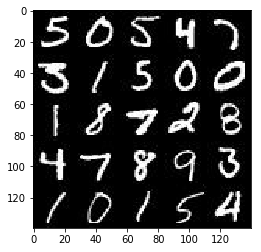

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

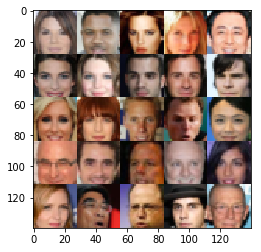

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_size = (None, image_width, image_height, image_channels)
    
    input_real = tf.placeholder(tf.float32, input_size, name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learn_rate
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:


def leaky_relu(input_layer, alpha=0.1):
    return tf.maximum(alpha * input_layer, input_layer)

def conv_layer(
    inputs,
    filters,
    padding='same',
    batch_normalize_inputs=False,
    batch_normalize_outputs=True, 
    activation=leaky_relu,
    transpose=False,
    training=True,
    dropout=None,
    kernel_initializer=None,
    **kwargs):
    
    next_layer = inputs
    if batch_normalize_inputs:
        next_layer = tf.layers.batch_normalization(
            input_layer, training=training)
    
    layer_type = {
        False: tf.layers.conv2d, 
        True: tf.layers.conv2d_transpose}[transpose]
    
    kernel_initializer = (
        kernel_initializer or 
        tf.contrib.layers.xavier_initializer())
    
    next_layer = layer_type(
        inputs=next_layer,
        filters=filters,
        padding=padding, 
        kernel_initializer=kernel_initializer,
        **kwargs)
    
    if dropout:
        next_layer = tf.layers.dropout(
            inputs=next_layer,
            rate=dropout,
            training=training,)
    
    if batch_normalize_outputs:
        next_layer = tf.layers.batch_normalization(
            next_layer, training=training)
        
    if activation:
        next_layer = activation(next_layer)
    
    return next_layer


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #rescale data
        images = (images * 2)
        
        # input is 28x28xZ
        
        
        layer1 = conv_layer(
            inputs=images, filters=64, 
            kernel_size=5, strides=2,
            batch_normalize_outputs=False, 
            dropout=0.1)
        
        # 14x14x32
        layer2 = conv_layer(
            inputs=layer1, filters=128, 
            kernel_size=5, strides=2, 
            dropout=0.1)
        
        # 7x7x64
        layer3 = conv_layer(
            inputs=layer2, filters=256, 
            kernel_size=5, strides=2, 
            dropout=0.1)
        
        # 4x4x128
        flat = tf.reshape(layer3, (-1, 4*4*64))
        logits = tf.layers.dense(
            flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:






def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(
            z, 7*7*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1)
        
        layer2 = conv_layer(
            layer1, filters=256, kernel_size=5, 
            strides=1, transpose=True, training=is_train)
        
        layer3 = conv_layer(
            layer2, filters=128, kernel_size=5, 
            strides=1, transpose=True, training=is_train)
        
        layer4 = conv_layer(
            layer3, filters=64, kernel_size=5, 
            strides=2, transpose=True, training=is_train)
        
        logits = conv_layer(
            layer4, filters=out_channel_dim, 
            kernel_size=5, strides=2, transpose=True, 
            training=is_train, batch_normalize_outputs=False)
        
        output = tf.tanh(logits)
        
        
    return output













"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(
        input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_logits_real)*(1-smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1, optimizer=tf.train.AdamOptimizer):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Optimizers
    learning_rate = 0.002

    t_vars = tf.trainable_variables()
    
    g_vars = list(filter(lambda v: v.name.startswith('generator'), t_vars))
    d_vars = list(filter(lambda v: v.name.startswith('discriminator'), t_vars))
    
    def opt():
        return optimizer(learning_rate=learning_rate, beta1=beta1)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = opt().minimize(d_loss, var_list=d_vars)
        g_train_opt = opt().minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(
    epoch_count, batch_size, z_dim, learning_rate, 
    beta1, get_batches, data_shape, data_image_mode, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    # return
    input_real, input_z, learn_placeholder = model_inputs(*data_shape[1:], z_dim=z_dim)
    out_channel_dim = data_shape[-1]
    d_loss, g_loss = model_loss(
        input_real=input_real, 
        input_z=input_z, 
        out_channel_dim=out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    global_batch_num = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("Epoch: {}".format(epoch_i))
            batch_num = 0
            for batch_images in get_batches(batch_size):
                batch_num += 1
                global_batch_num += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                feed_dict = {
                    input_real: batch_images, 
                    input_z: batch_z, 
                    learn_placeholder: learning_rate}
                sess.run(d_train_opt, feed_dict=feed_dict)
                sess.run(g_train_opt, feed_dict=feed_dict)
                sess.run(g_train_opt, feed_dict=feed_dict)
            
                if not batch_num % 100:
                    print('Batch: {}'.format(batch_num))
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if not batch_num % show_every or global_batch_num in[1,5,10,25,50,100,200,300,400]:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
    
        show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 0


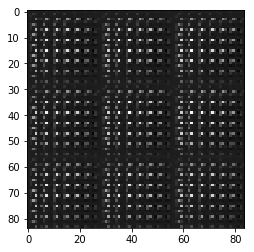

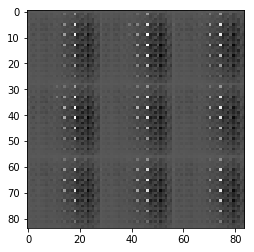

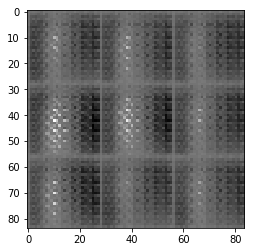

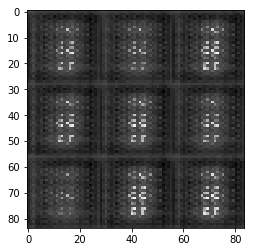

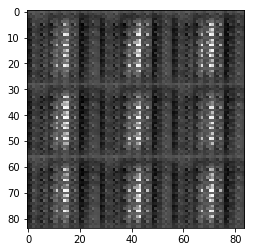

Batch: 100
Discriminator Loss: 1.3751... Generator Loss: 0.8292


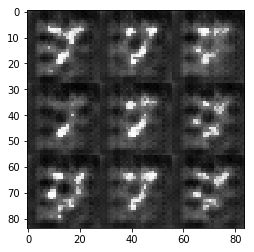

Batch: 200
Discriminator Loss: 1.0106... Generator Loss: 1.2555


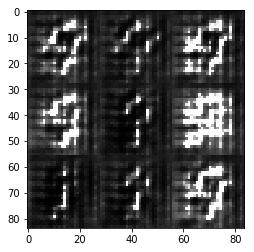

Batch: 300
Discriminator Loss: 1.0732... Generator Loss: 1.0673


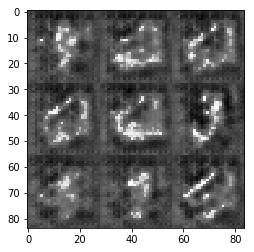

Batch: 400
Discriminator Loss: 1.2213... Generator Loss: 1.5696


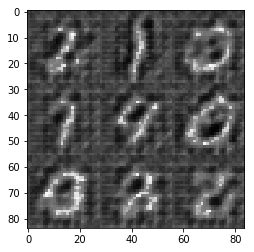

Batch: 500
Discriminator Loss: 1.0090... Generator Loss: 0.8178


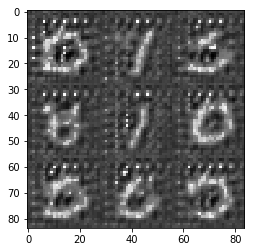

Batch: 600
Discriminator Loss: 0.4103... Generator Loss: 3.4691


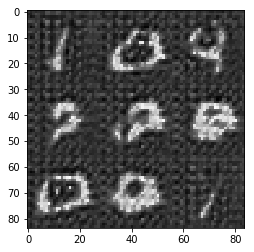

Batch: 700
Discriminator Loss: 0.9046... Generator Loss: 1.0457


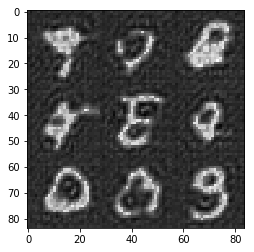

Batch: 800
Discriminator Loss: 0.9912... Generator Loss: 0.8560


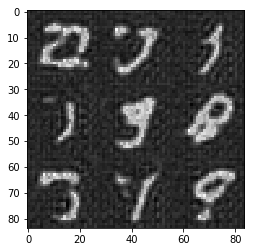

Batch: 900
Discriminator Loss: 1.0791... Generator Loss: 0.8018


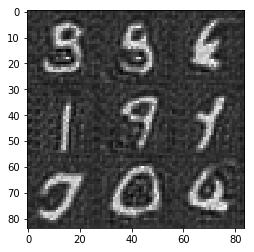

Batch: 1000
Discriminator Loss: 0.9833... Generator Loss: 0.8247


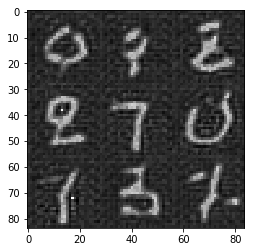

Batch: 1100
Discriminator Loss: 1.0682... Generator Loss: 1.2463


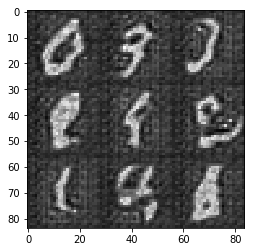

Batch: 1200
Discriminator Loss: 1.1966... Generator Loss: 0.6465


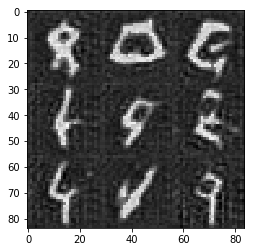

Batch: 1300
Discriminator Loss: 0.5493... Generator Loss: 1.9480


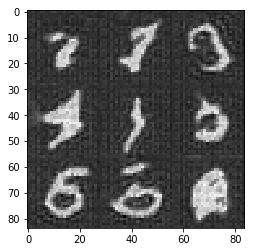

Batch: 1400
Discriminator Loss: 0.3732... Generator Loss: 3.9143


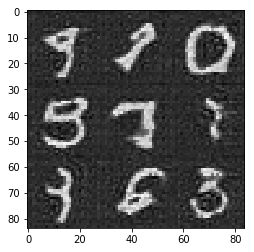

Batch: 1500
Discriminator Loss: 2.0099... Generator Loss: 0.2471


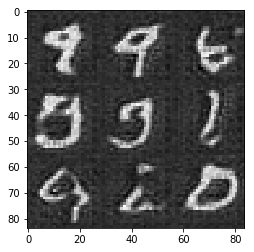

Batch: 1600
Discriminator Loss: 1.0986... Generator Loss: 1.3488


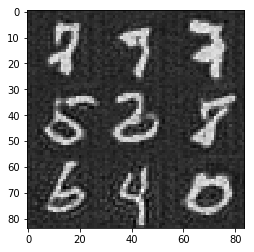

Batch: 1700
Discriminator Loss: 1.4509... Generator Loss: 0.4663


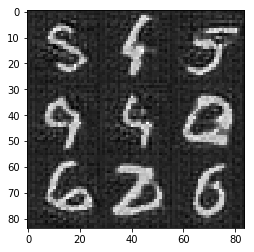

Batch: 1800
Discriminator Loss: 0.5556... Generator Loss: 2.2641


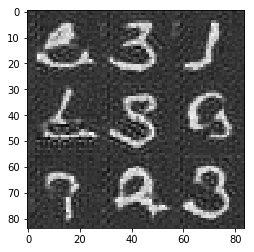

Epoch: 1
Batch: 100
Discriminator Loss: 0.9792... Generator Loss: 1.8911


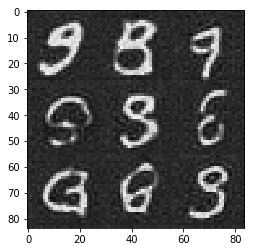

Batch: 200
Discriminator Loss: 1.7930... Generator Loss: 0.3579


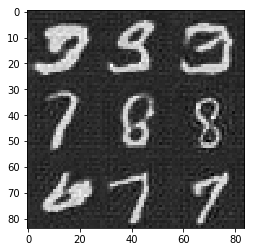

Batch: 300
Discriminator Loss: 0.5749... Generator Loss: 2.0067


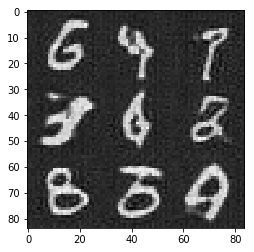

Batch: 400
Discriminator Loss: 1.0811... Generator Loss: 0.8663


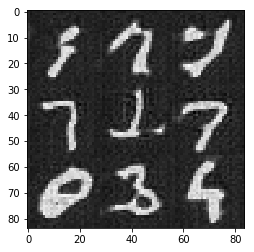

Batch: 500
Discriminator Loss: 1.3289... Generator Loss: 0.7785


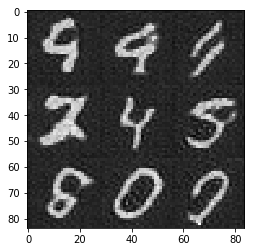

Batch: 600
Discriminator Loss: 2.8299... Generator Loss: 0.1359


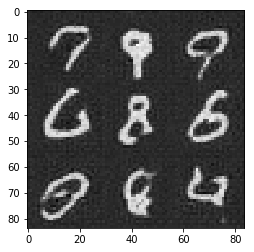

Batch: 700
Discriminator Loss: 0.5534... Generator Loss: 1.9591


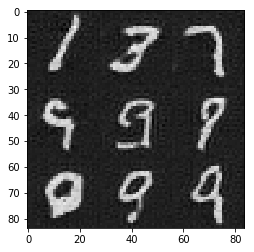

Batch: 800
Discriminator Loss: 1.0065... Generator Loss: 1.0780


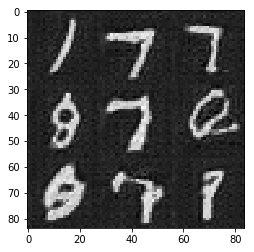

Batch: 900
Discriminator Loss: 0.7000... Generator Loss: 1.5549


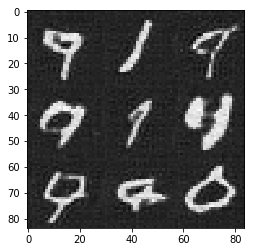

Batch: 1000
Discriminator Loss: 1.2657... Generator Loss: 0.8128


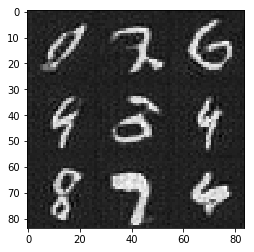

Batch: 1100
Discriminator Loss: 0.9794... Generator Loss: 1.1266


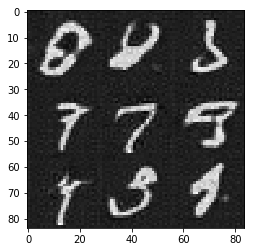

Batch: 1200
Discriminator Loss: 1.5363... Generator Loss: 0.5881


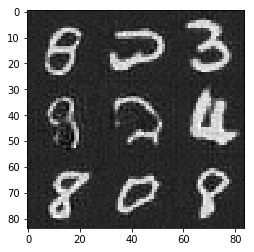

Batch: 1300
Discriminator Loss: 0.8561... Generator Loss: 1.0305


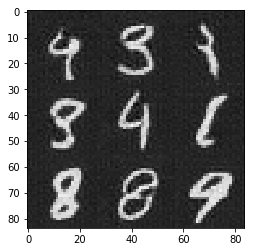

Batch: 1400
Discriminator Loss: 1.1988... Generator Loss: 0.7432


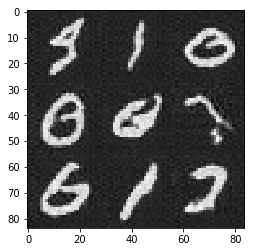

Batch: 1500
Discriminator Loss: 1.2732... Generator Loss: 0.5241


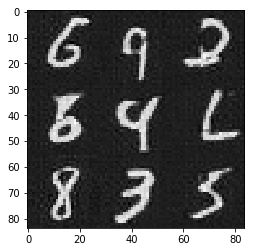

Batch: 1600
Discriminator Loss: 1.0951... Generator Loss: 1.1047


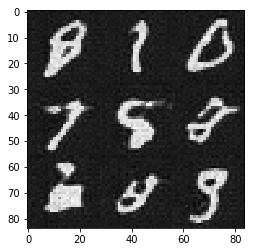

Batch: 1700
Discriminator Loss: 0.5447... Generator Loss: 2.1062


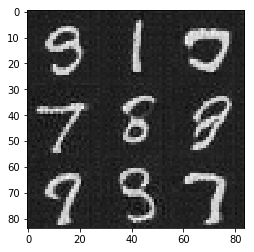

Batch: 1800
Discriminator Loss: 1.9359... Generator Loss: 0.2629


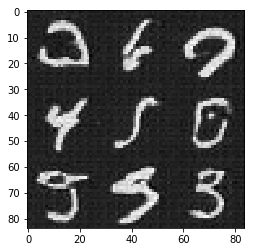

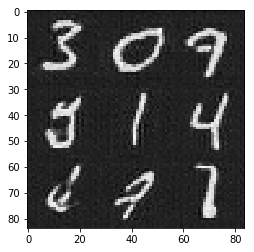

In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 0


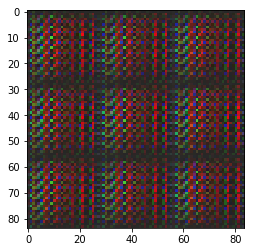

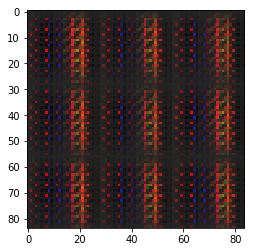

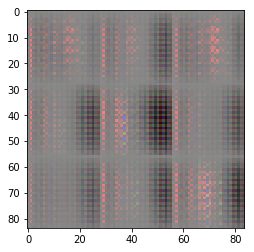

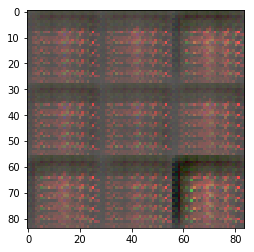

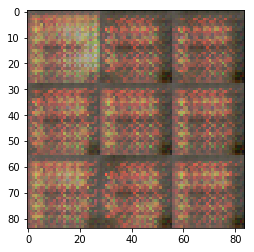

Batch: 100
Discriminator Loss: 1.5622... Generator Loss: 0.5590


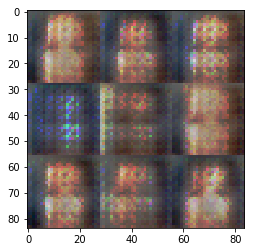

Batch: 200
Discriminator Loss: 1.4140... Generator Loss: 0.8000


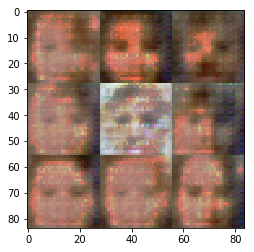

Batch: 300
Discriminator Loss: 1.5065... Generator Loss: 0.5818


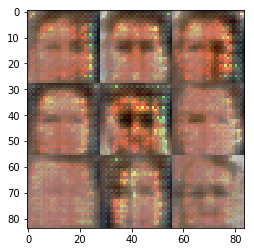

Batch: 400
Discriminator Loss: 1.4592... Generator Loss: 0.5227


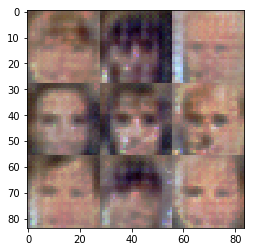

Batch: 500
Discriminator Loss: 1.4056... Generator Loss: 0.8038


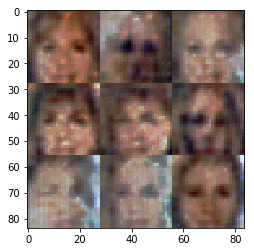

Batch: 600
Discriminator Loss: 1.3572... Generator Loss: 0.7001


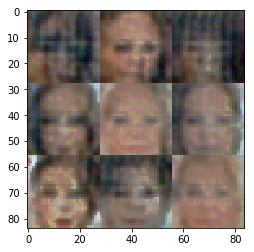

Batch: 700
Discriminator Loss: 1.5944... Generator Loss: 0.9627


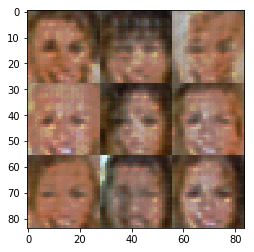

Batch: 800
Discriminator Loss: 1.2861... Generator Loss: 0.9477


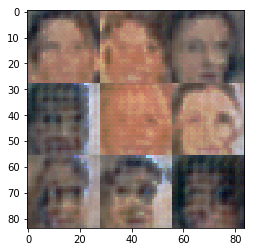

Batch: 900
Discriminator Loss: 1.3833... Generator Loss: 0.7856


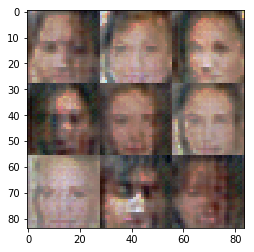

Batch: 1000
Discriminator Loss: 1.2926... Generator Loss: 0.7215


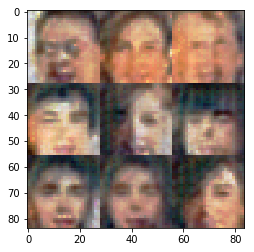

Batch: 1100
Discriminator Loss: 1.2122... Generator Loss: 0.8939


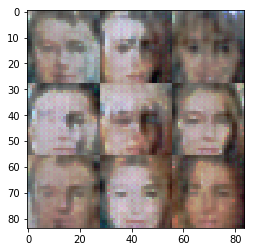

Batch: 1200
Discriminator Loss: 1.3822... Generator Loss: 0.8229


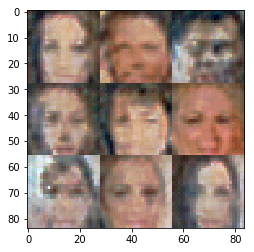

Batch: 1300
Discriminator Loss: 1.3845... Generator Loss: 0.7418


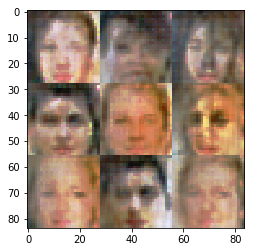

Batch: 1400
Discriminator Loss: 2.2099... Generator Loss: 2.0469


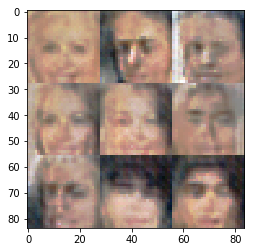

Batch: 1500
Discriminator Loss: 1.3876... Generator Loss: 0.7645


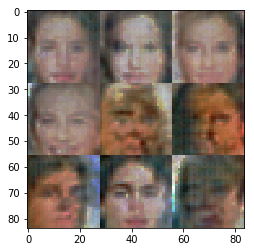

Batch: 1600
Discriminator Loss: 1.4243... Generator Loss: 0.7548


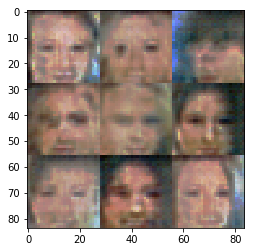

Batch: 1700
Discriminator Loss: 1.5216... Generator Loss: 1.4031


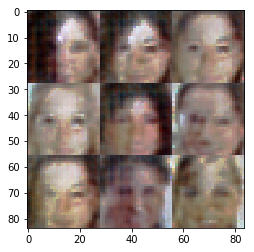

Batch: 1800
Discriminator Loss: 1.1578... Generator Loss: 1.0396


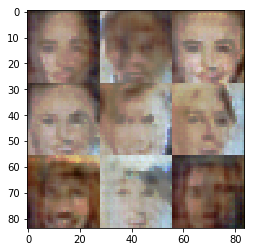

Batch: 1900
Discriminator Loss: 1.3848... Generator Loss: 1.1098


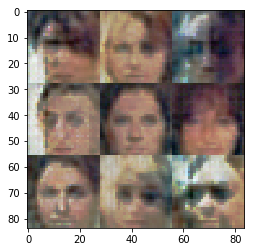

Batch: 2000
Discriminator Loss: 0.7253... Generator Loss: 1.3451


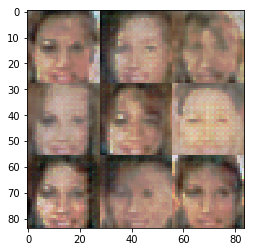

Batch: 2100
Discriminator Loss: 1.1127... Generator Loss: 0.9359


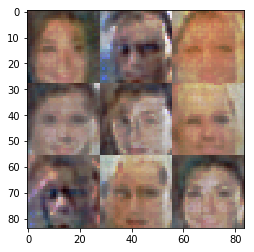

Batch: 2200
Discriminator Loss: 1.3884... Generator Loss: 0.7261


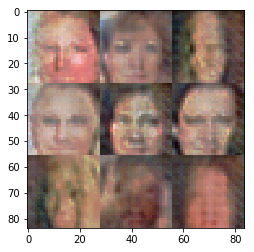

Batch: 2300
Discriminator Loss: 1.2549... Generator Loss: 0.6202


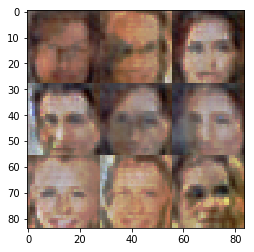

Batch: 2400
Discriminator Loss: 1.5226... Generator Loss: 0.5971


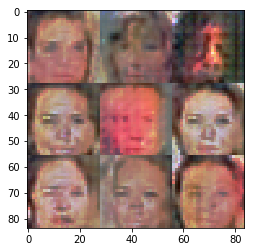

Batch: 2500
Discriminator Loss: 1.3212... Generator Loss: 1.4479


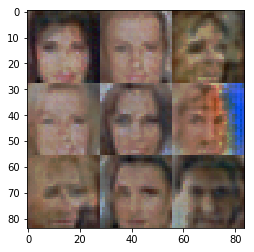

Batch: 2600
Discriminator Loss: 1.7285... Generator Loss: 1.7344


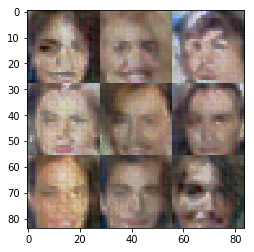

Batch: 2700
Discriminator Loss: 1.6051... Generator Loss: 0.4665


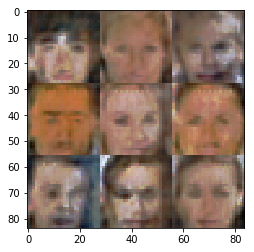

Batch: 2800
Discriminator Loss: 1.3117... Generator Loss: 0.7336


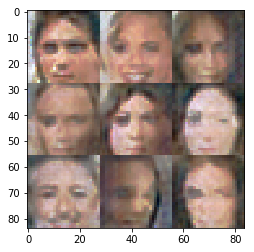

Batch: 2900
Discriminator Loss: 1.3399... Generator Loss: 1.6549


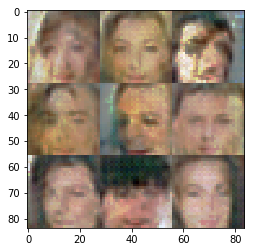

Batch: 3000
Discriminator Loss: 1.1923... Generator Loss: 0.8403


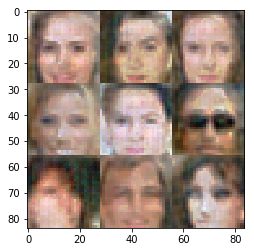

Batch: 3100
Discriminator Loss: 0.9468... Generator Loss: 0.9861


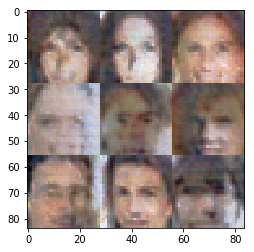

Batch: 3200
Discriminator Loss: 0.3682... Generator Loss: 3.7800


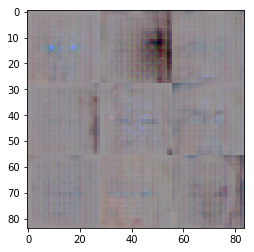

Batch: 3300
Discriminator Loss: 1.4455... Generator Loss: 0.8087


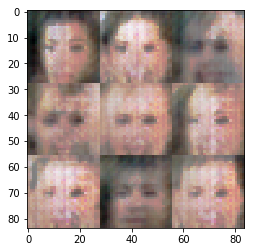

Batch: 3400
Discriminator Loss: 0.9361... Generator Loss: 1.0307


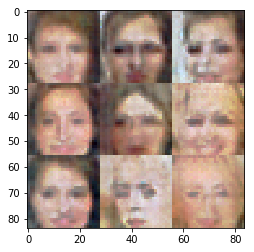

Batch: 3500
Discriminator Loss: 1.8167... Generator Loss: 0.3058


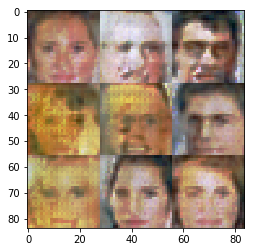

Batch: 3600
Discriminator Loss: 1.3214... Generator Loss: 0.6666


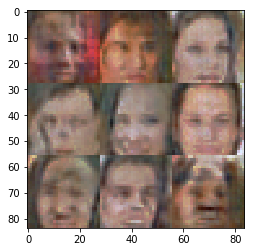

Batch: 3700
Discriminator Loss: 1.2493... Generator Loss: 0.8250


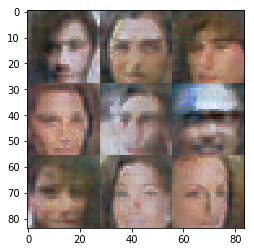

Batch: 3800
Discriminator Loss: 0.3763... Generator Loss: 3.7163


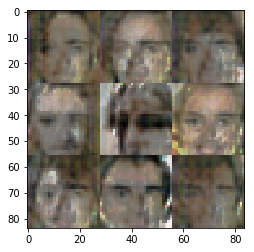

Batch: 3900
Discriminator Loss: 1.3929... Generator Loss: 0.5333


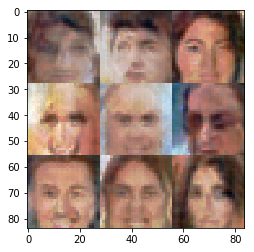

Batch: 4000
Discriminator Loss: 0.9655... Generator Loss: 2.0713


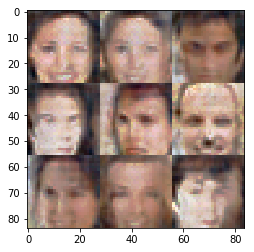

Batch: 4100
Discriminator Loss: 1.0868... Generator Loss: 0.9573


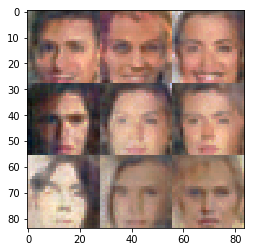

Batch: 4200
Discriminator Loss: 1.0621... Generator Loss: 1.0309


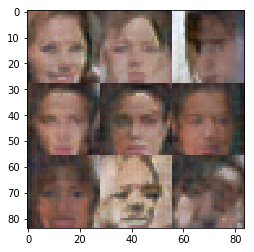

Batch: 4300
Discriminator Loss: 2.1068... Generator Loss: 0.2340


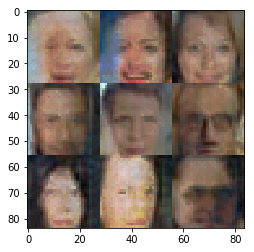

Batch: 4400
Discriminator Loss: 2.6810... Generator Loss: 2.6498


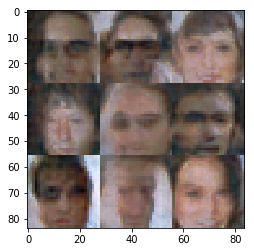

Batch: 4500
Discriminator Loss: 0.5043... Generator Loss: 2.2160


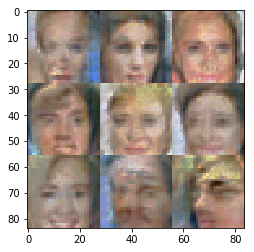

Batch: 4600
Discriminator Loss: 1.0166... Generator Loss: 1.7269


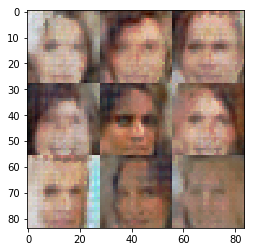

Batch: 4700
Discriminator Loss: 1.4571... Generator Loss: 0.5276


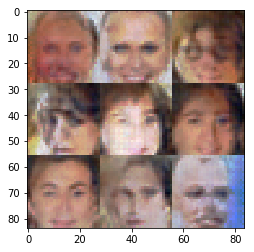

Batch: 4800
Discriminator Loss: 0.7219... Generator Loss: 3.0827


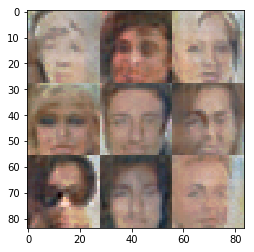

Batch: 4900
Discriminator Loss: 1.3264... Generator Loss: 0.5839


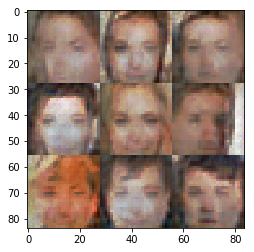

Batch: 5000
Discriminator Loss: 0.4420... Generator Loss: 2.5071


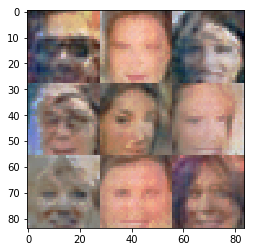

Batch: 5100
Discriminator Loss: 0.3629... Generator Loss: 4.0938


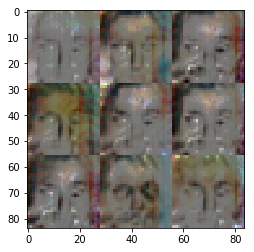

Batch: 5200
Discriminator Loss: 0.3452... Generator Loss: 5.8402


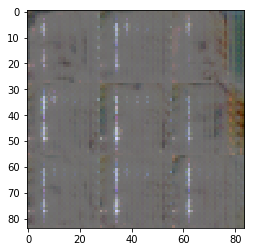

Batch: 5300
Discriminator Loss: 0.3401... Generator Loss: 5.0605


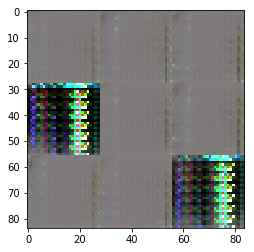

Batch: 5400
Discriminator Loss: 0.8228... Generator Loss: 1.1180


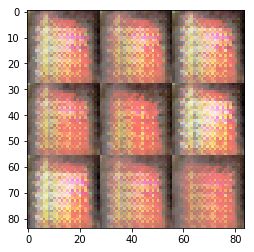

Batch: 5500
Discriminator Loss: 0.3827... Generator Loss: 4.1558


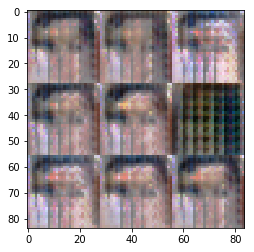

Batch: 5600
Discriminator Loss: 1.7822... Generator Loss: 0.3452


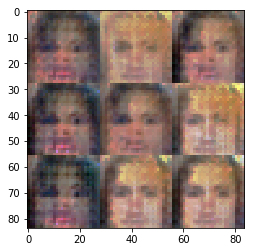

Batch: 5700
Discriminator Loss: 0.3632... Generator Loss: 5.1162


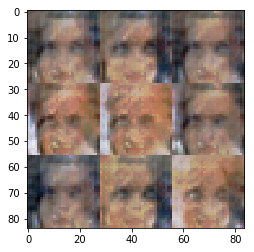

Batch: 5800
Discriminator Loss: 0.9490... Generator Loss: 3.5472


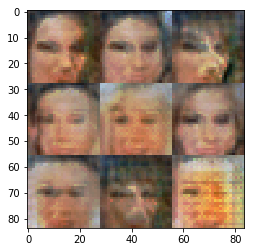

Batch: 5900
Discriminator Loss: 1.2400... Generator Loss: 3.4736


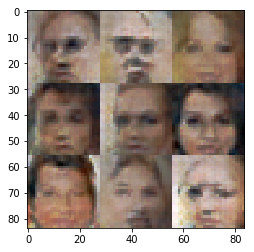

Batch: 6000
Discriminator Loss: 0.8736... Generator Loss: 1.2334


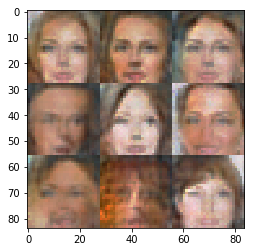

Batch: 6100
Discriminator Loss: 0.9869... Generator Loss: 3.1930


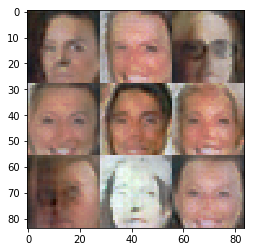

Batch: 6200
Discriminator Loss: 0.5395... Generator Loss: 2.3106


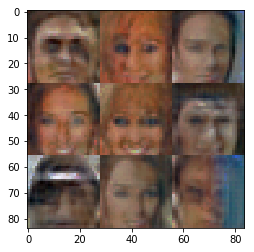

Batch: 6300
Discriminator Loss: 0.4313... Generator Loss: 3.0317


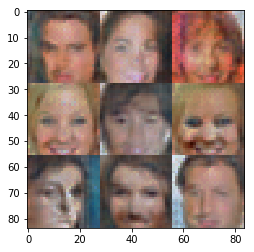

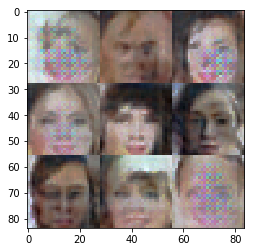

In [57]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.